In [52]:
import re
import random
import pandas as pd
import hashlib

In [53]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.75) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [54]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
SharePoint,55.159525,3.244678,17
Azure AI Search,242.420347,17.315739,14
Network Mapping,398.979843,18.999040,21
Lost in a Good Book,417.076794,20.853840,20
sklearn,420.862452,140.287484,3
MS Identity Platform,655.505867,93.643695,7
Taxes,814.861136,81.486114,10
Finance Junk,979.740131,122.467516,8
Search Engine Optimization,1054.850650,62.050038,17
Open Source/GitHub,1206.993306,52.477970,23


# Histogram

41549.39


<Axes: >

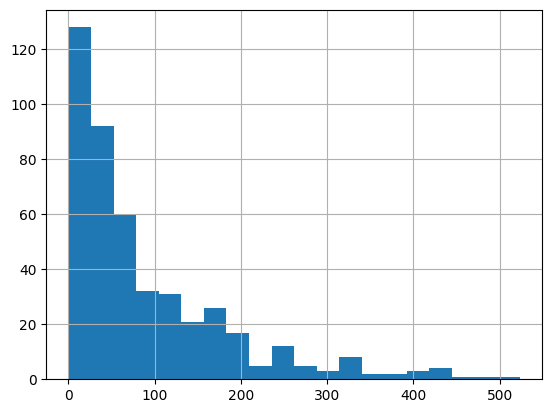

In [55]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [56]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [57]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [58]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Focus on one header

In [59]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [60]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [61]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [62]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [63]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [64]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [65]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 454


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
229,Azure Kubernetes Learning Path,Enter the following code to start the sample a...,81ce6837f1e2dda15a58f770fd43cba1,-522.950471,157.128522,-522.950471,3456.827494,0.523263,0,0
232,Azure Kubernetes Learning Path,The docker build command creates a new image b...,9549cb09e4005ee53d85dcf02968bf4b,-320.672712,157.128522,-522.950471,3456.827494,0.523263,3,0
235,Azure Kubernetes Learning Path,"For more advanced scenarios, both Linux and Wi...",592a1c0e1950e18da3b1510f3768d9fb,-189.414470,157.128522,-522.950471,3456.827494,0.523263,6,0
237,Azure Kubernetes Learning Path,Docker images are stored and made available in...,95fd50f6b06189a75d6d6bed669d0421,-150.741251,157.128522,-522.950471,3456.827494,0.523263,9,0
241,Azure Kubernetes Learning Path,You push an image from your local computer to ...,c7ff738847ea6fee50edc51961d04a2b,-88.708847,157.128522,-522.950471,3456.827494,0.523263,12,0
244,Azure Kubernetes Learning Path,Azure Container Instance is a service that loa...,dda972de0f461195a5556213d611eb72,-50.642114,157.128522,-522.950471,3456.827494,0.523263,15,0
247,Azure Kubernetes Learning Path,A volume is stored on the host filesystem at a...,c488a693b93a4bd4eb81e68654db4018,-35.810624,157.128522,-522.950471,3456.827494,0.523263,18,0
250,Azure Kubernetes Learning Path,The following example creates an alias for the...,141254979388bea3e62d8f2681c057ca,-15.342735,157.128522,-522.950471,3456.827494,0.523263,21,0
365,OData,Inheritance Hierarchies allow entities to deri...,7783a0aba0edbf8c080e2b37f662aca7,-472.981162,91.785800,-472.981162,2386.430810,0.758315,0,0
368,OData,Delta Queries allow clients to track changes (...,27d24f93b4b1b48bb6885dad01847dea,-145.950719,91.785800,-472.981162,2386.430810,0.758315,3,0


## Age Mean

In [66]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)


In [67]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
229,Azure Kubernetes Learning Path,Enter the following code to start the sample a...,81ce6837f1e2dda15a58f770fd43cba1,-522.950471,157.128522,-522.950471,3456.827494,0.523263,0,0
232,Azure Kubernetes Learning Path,The docker build command creates a new image b...,9549cb09e4005ee53d85dcf02968bf4b,-320.672712,157.128522,-522.950471,3456.827494,0.523263,3,0
235,Azure Kubernetes Learning Path,"For more advanced scenarios, both Linux and Wi...",592a1c0e1950e18da3b1510f3768d9fb,-189.414470,157.128522,-522.950471,3456.827494,0.523263,6,0
237,Azure Kubernetes Learning Path,Docker images are stored and made available in...,95fd50f6b06189a75d6d6bed669d0421,-150.741251,157.128522,-522.950471,3456.827494,0.523263,9,0
241,Azure Kubernetes Learning Path,You push an image from your local computer to ...,c7ff738847ea6fee50edc51961d04a2b,-88.708847,157.128522,-522.950471,3456.827494,0.523263,12,0
244,Azure Kubernetes Learning Path,Azure Container Instance is a service that loa...,dda972de0f461195a5556213d611eb72,-50.642114,157.128522,-522.950471,3456.827494,0.523263,15,0
247,Azure Kubernetes Learning Path,A volume is stored on the host filesystem at a...,c488a693b93a4bd4eb81e68654db4018,-35.810624,157.128522,-522.950471,3456.827494,0.523263,18,0
250,Azure Kubernetes Learning Path,The following example creates an alias for the...,141254979388bea3e62d8f2681c057ca,-15.342735,157.128522,-522.950471,3456.827494,0.523263,21,0
365,OData,Inheritance Hierarchies allow entities to deri...,7783a0aba0edbf8c080e2b37f662aca7,-472.981162,91.785800,-472.981162,2386.430810,0.758315,0,0
368,OData,Delta Queries allow clients to track changes (...,27d24f93b4b1b48bb6885dad01847dea,-145.950719,91.785800,-472.981162,2386.430810,0.758315,3,0


In [68]:
existing_cards.head(10)['age'].sum()

-1993.2151043142835